In [1]:
import pandas as pd
import numpy as np
import json
import bs4
from bs4 import BeautifulSoup
import re
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [2]:
print(pd.__version__)
print(np.__version__)
print(json.__version__)
print(bs4.__version__)
print(re.__version__)
print(sns.__version__)
print(matplotlib.__version__)

1.4.1
1.21.5
2.0.9
4.10.0
2.2.1
0.11.2
3.5.1


In [3]:
sources = json.load(open("predictions.json"))
df = pd.read_excel("entry_extraction_feedback.xlsx")
df["Reviewer"] = df["Reviewer"].str.strip()
df["Entries"] = df["Entries"].apply(eval)

Load the text, and the character spans which contain text highlighted by the ML system.

In [4]:
texts = {}
relevancies = {}

for key in sources.keys():
    text = ""
    is_relevant = []
    
    for child in BeautifulSoup(sources[key]).find("p").find_all(text=True):
        child_text = re.sub(r"\s+", " ", str(child))
        length = len(child_text)
        text += child_text

        if child.parent.name == "span":
            is_relevant.extend([1] * length)
        else:
            is_relevant.extend([0] * length)

    is_relevant = np.array(is_relevant, dtype=bool)
    
    lead_id = int(key.split(",")[0])
    
    texts[lead_id] = text
    relevancies[lead_id] = is_relevant

In [5]:
def get_relevant_characters(text, entries):
    """
    Compute the characters which are marked as relevant, given a text and entries.
    Also keeps track of for how many entries no match can be found in the text.
    """
    is_relevant = np.zeros(len(text), dtype=bool)
    
    n_no_match = 0
    
    for entry in entries:
        if entry == "nan":
            continue
        entry = re.sub(r"\s+", " ", entry)
        
        try:
            start = text.index(entry)
            end = start + len(entry)
            is_relevant[start:end] = True
        except ValueError:
            n_no_match += 1
            
    return is_relevant, n_no_match

Some rows have the wrong Lead ID (signified by many entries for which no match can be found.)

Fix this by searching for the lead with the lowest number of non-matching entries.

In [6]:
def fix_lead_id(row):
    best_lead_id = row["Lead ID"]
    original_lead_id = best_lead_id
    _, best_n_no_match = get_relevant_characters(texts[best_lead_id], row["Entries"])
    original_n_no_match = best_n_no_match
    
    for lead_id, text in texts.items():
        _, n_no_match = get_relevant_characters(texts[lead_id], row["Entries"])
        
        if n_no_match < best_n_no_match:
            best_lead_id = lead_id
            best_n_no_match = n_no_match
            
    if best_lead_id != original_lead_id:
        print(f"Changed {original_lead_id} to {best_lead_id}. {best_n_no_match} non-matching entries remaining"
              f" (from {original_n_no_match}).")
    
    row["Lead ID"] = best_lead_id
    return row
    
    
df = df.apply(fix_lead_id, axis=1)

Changed 74413 to 74411. 0 non-matching entries remaining (from 6).
Changed 74671 to 74668. 0 non-matching entries remaining (from 7).
Changed 74377 to 74370. 0 non-matching entries remaining (from 2).
Changed 74382 to 74378. 0 non-matching entries remaining (from 2).
Changed 74283 to 74280. 0 non-matching entries remaining (from 3).
Changed 74681 to 74671. 0 non-matching entries remaining (from 1).
Changed 74363 to 74360. 0 non-matching entries remaining (from 2).
Changed 74267 to 74266. 0 non-matching entries remaining (from 2).
Changed 74550 to 74382. 0 non-matching entries remaining (from 1).
Changed 74183 to 74178. 0 non-matching entries remaining (from 2).
Changed 74176 to 74169. 0 non-matching entries remaining (from 3).
Changed 74284 to 74283. 0 non-matching entries remaining (from 1).
Changed 74601 to 74587. 0 non-matching entries remaining (from 3).
Changed 74671 to 74668. 0 non-matching entries remaining (from 6).
Changed 74377 to 74370. 0 non-matching entries remaining (from

Check number of texts each tagger annotated.

In [7]:
df["Reviewer"].value_counts()

Priyanka Sharma    105
Prinisha Baidya    104
Nagma Mathema      100
Pooja Sharma        96
Sneha Pandey         8
Name: Reviewer, dtype: int64

Divide into four sets:
- `n1`: the first tagger who did not see highlights.
- `n2`: the second tagger who did not see highlights.
- `h1`: the first tagger who saw highlights.
- `h2`: the second tagger who saw highlights.

In [8]:
n1 = df[df["Reviewer"] == "Priyanka Sharma"]
n1 = n1[~n1["Lead ID"].duplicated()]
assert not n1["Entry Highlight"].any()
n1.set_index("Lead ID", inplace=True)

h1 = df[df["Reviewer"] == "Prinisha Baidya"]
h1 = h1[~h1["Lead ID"].duplicated()]
assert h1["Entry Highlight"].all()
h1.set_index("Lead ID", inplace=True)

n2 = df[df["Reviewer"] == "Pooja Sharma"]
n2 = n2[~n2["Lead ID"].duplicated()]
assert not n2["Entry Highlight"].any()
n2.set_index("Lead ID", inplace=True)

h2 = df[df["Reviewer"] == "Nagma Mathema"]
h2 = h2[~h2["Lead ID"].duplicated()]
assert h2["Entry Highlight"].all()
h2.set_index("Lead ID", inplace=True)

Interestingly, only 67 lead IDs overlap between all of the taggers. Some further analysis would be warranted.

In [9]:
key_intersection = sorted(set(n1.index) & set(h1.index) & set(n2.index) & set(h2.index))
len(key_intersection)

67

Agreement between two sources of spans (either taggers or the ML system) is computed as IoU i.e. the intersection of highlighted characters between the two over the union of the highlighted characters. Could be expanded to also compute ROUGE scores.

In [10]:
def get_iou(a, b):
    """
    Get the IoU between entries from `a` and `b`.
    """
    total_a = 0
    total_b = 0
    total_a_no_match = 0
    total_b_no_match = 0

    all_ious = []

    for key in key_intersection:
        total_a += len(a.loc[key]["Entries"])
        total_b += len(b.loc[key]["Entries"])

        mask_a, n_no_match_a = get_relevant_characters(texts[key], a.loc[key]["Entries"])
        mask_b, n_no_match_b = get_relevant_characters(texts[key], b.loc[key]["Entries"])

        total_a_no_match += n_no_match_a
        total_b_no_match += n_no_match_b

        iou = (mask_a & mask_b).sum() / ((mask_a | mask_b).sum()) if (mask_a | mask_b).any() else 1
        all_ious.append(iou)
    
    return np.mean(all_ious)

def get_overlap_with_predicted(a):
    """
    Get the IoU of the entries `a` with the ML-system highlights.
    """
    all_ious = []
    
    for key in key_intersection:
        mask_a, n_no_match_a = get_relevant_characters(texts[key], a.loc[key]["Entries"])
        mask_b = relevancies[key]
        
        iou = (mask_a & mask_b).sum() / ((mask_a | mask_b).sum()) if (mask_a | mask_b).any() else 1
        
        all_ious.append(iou)
        
    return np.mean(all_ious)

# Pairwise agreement

Compute a confusion matrix of the pairwise agreement between all taggers.

In [11]:
results = np.zeros((4, 4))

for i, a in enumerate([h1, h2, n1, n2]):
    for j, b in enumerate([h1, h2, n1, n2]):
        results[i, j] = get_iou(a, b)

Text(0.5, 1.0, 'Intersection Over Union of spans marked as relevant')

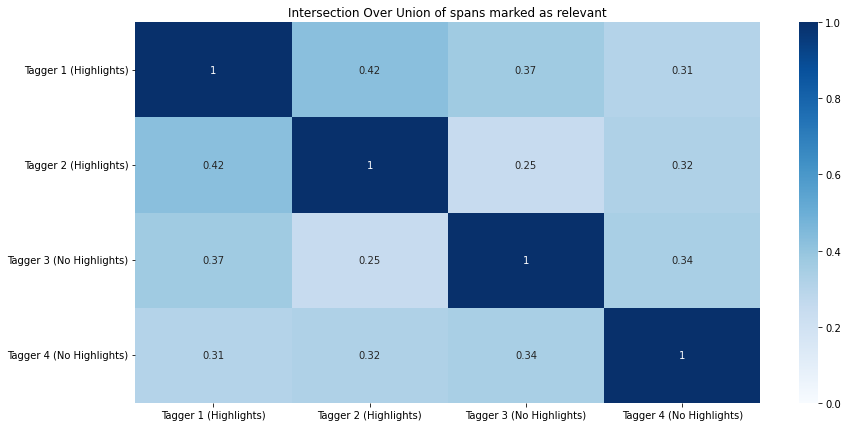

In [12]:
plt.figure(figsize=(14, 7))
sns.heatmap(results, annot=True, vmin=0.0, vmax=1.0, 
            cmap="Blues",
            xticklabels=["Tagger 1 (Highlights)", "Tagger 2 (Highlights)", "Tagger 3 (No Highlights)", "Tagger 4 (No Highlights)"], 
            yticklabels=["Tagger 1 (Highlights)", "Tagger 2 (Highlights)", "Tagger 3 (No Highlights)", "Tagger 4 (No Highlights)"])

plt.title("Intersection Over Union of spans marked as relevant")

Compute the average agreement between taggers of different kinds (avg. of lower left / upper right in the confusion matrix).

In [13]:
print(f"{results[2:, :2].mean():.3f}")

0.312


# Compute agreement between the taggers and the ML-system

## Tagger 1 (with Highlights)

In [14]:
print(f"{get_overlap_with_predicted(h1):.3f}")

0.356


## Tagger 2 (with Highlights)

In [15]:
print(f"{get_overlap_with_predicted(h2):.3f}")

0.410


## Tagger 3 (no Highlights)

In [16]:
print(f"{get_overlap_with_predicted(n1):.3f}")

0.264


## Tagger 4 (no Highlights)

In [17]:
print(f"{get_overlap_with_predicted(n2):.3f}")

0.247


In [18]:
(0.264+0.247)/2

0.2555

# Conclusion

- Which excepts are relevant is somewhat subjective: there is only agreement of 0.34 (from 0 to 1) between both taggers which did not see highlights.
- There seems to have been some mistake in the data collection process assigning wrong Lead IDs to many entries. Luckily this is easily fixable.
- The ML-system biases the taggers: Average agreement with the highlights is:
    - 0.38 for the taggers who did see highlights.
    - 0.26 for the taggers who did not see highlights.
- This also manifests itself in higher agreement between the taggers who saw highlights (0.42) since both are biased toward the highlights.
- The highlights are quite good: As mentioned above the agreement of the taggers who did not see highlights with the highlights is 0.26, while their agreement with each other is 0.34, which would be a reasonable upper bound on the performance of the ML-system.

# Next steps

- The most important next step is asking the taggers what they think about the system: If it is useful, makes them more productive, etc.
- There's some ways in which this analysis could be expanded:
    - Computing ROUGE score in addition to IoU and checking if the same conclusions hold.
    - Checking why only 67 Lead IDs overlap between all taggers (expected would be 100).
    - Checking whether the model over/underpredicts (Precision/Recall metrics).